In [29]:
## Current script with hopes of being the master script, applicable for all processes/tools/steps/wavelengths/etc
import pandas as pd
import glob
import os
import numpy as np
from datetime import datetime,timedelta
import time
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import interpolate, stats
import seaborn as sns
from tqdm import tqdm                       # For progress bar, yay!


In [30]:
# Retrieving Metro Data from .txt files
mfile = []
metro = {}
metro_cols = ['waferscribe','ext_mv'] # ext_mv is the column containing the metro parameter values
print('Reading Metro Data')
for filename in glob.glob("metro/22*"): # Reading txt files
        # Only reading the previously defined columns with the filename as a key
    metro[filename[6:-4]] = pd.read_csv(filename,usecols=metro_cols)[metro_cols] # type(metro) = dict
        # Create index of filename strings ...Maybe I don't need this...
    mfile.append(filename[6:-4])
        # Turning into DataFrame to help with Memeory Errors
    met = pd.concat(metro.values(),ignore_index=True) # type(met) = pandas.core.frame.DataFrame
    print(f'\t{filename} Data Finished')

    # Trim down 'met' to relevant metro parameter values (This is broken down due to previous error troubleshooting, can be condensed)
paramVal = met['ext_mv']          # type(paramVal)    = pandas.core.series.Series
paramBool = met[paramVal%1==0]    # type(paramBool)   = pandas.core.frame.DataFrame
dropParam = paramBool.index       # type(dropParam)   = pandas.core.indexes.numeric.Int64Index
    # Removing values with decimal values = 0
met.drop(dropParam, inplace=True) 
MetroWafers = met.waferscribe     # type(MetroWafers) = pandas.core.series.Series

Reading Metro Data
	metro\22STIINT.txt Data Finished


In [31]:
# Retrieving OES Data from the .csv files, takes MUCH longer, retrieving specfic columns helps
ofile = []
oes = {}
data = {}
    # Less 22STI columns to prevent the MemoryError from popping up
oes_cols = ['WAFER_SCRIBE','RunStartTime','TimeStamp','StepID','OES_CO483','OES_C516','OES_CN387'] # 22STI
    # Full 22STI columns that will yield a MemoryError UNLESS, only a single 22STI file is being read
#oes_cols = ['WAFER_SCRIBE','RunStartTime','TimeStamp','StepID','OES_BCl272','OES_C516','OES_CN387','OES_CO483','OES_F703','OES_H656','OES_O777','OES_OH309','OES_Si251','OES_Si288'] # 22STI
    # GHContact Columns
#oes_cols = ['WAFER_SCRIBE','RunStartTime','TimeStamp','StepID','OESIB1','OESIB2','OESIB3','OESIB4','OESIB5','OESIB6','OESIB7','OESIB8'] # GHContact
    # Note: OES_* corresponds to an AMAT tool(22STI), OESIB* corresponds to a LAM tool(GHContact)
print('Reading OES Data')
    # 5030-22 STI INTEGRATED DRY ETCH_2 
    # 3500-GH CONTACT OXIDE DRY ETCH_1.csv
for filename in glob.glob("oes/5030-22 STI INTEGRATED DRY ETCH_2.csv"): 
        # Reading OES data with previously defined columns, parsing dates and infering format
    oes[filename[4:-4]] = pd.read_csv(filename,                            # type(oes) = dict
                                      usecols=oes_cols,
                                      parse_dates=['RunStartTime', 'TimeStamp'],
                                      infer_datetime_format=True)[oes_cols] 
        # Create index of filename strings ...Maybe I don't need this...
    ofile.append(filename[4:-4]) 
        # Turning into DataFrame to help with Memeory Errors
    data = pd.concat(oes.values(),ignore_index=True)                       # type(data) = pandas.core.frame.DataFrame
    print(f'\t{filename} Data Finished')

    # Array of unique wafers within an OES data set
UniqueWaferArray = data.WAFER_SCRIBE.unique()                       # type(UniqueWafers) = numpy.ndarray
    # An inverted bool array of whether those unique wafers match any wafers in the metro data 
nonWafers = np.isin(UniqueWaferArray,list(MetroWafers),invert=True) # type(nonWafers)    = numpy.ndarray
i = np.where(nonWafers)[0]                                      # type(i)            = numpy.ndarray
    # Identify the wafers that don't have a metro parameter, used in NEXT loop
WaferScribe = (UniqueWaferArray[i])                                 # type(WaferScribe)  = numpy.ndarray

Reading OES Data
	oes/5030-22 STI INTEGRATED DRY ETCH_2.csv Data Finished


In [4]:
print('Trimming Down Data to Only Metro-Matching Wafers') 
    # Having just the data for the wafers that have available metro parameters removes the possibility of accidentally using 
    # data that has no associated metro parameter. Including that data may skew the model building and therefore the results.
indexNames = []
for x in tqdm(WaferScribe):                # For a wafer in the array of wafers that don't have a metro parameter,
    WaferScribeData = data['WAFER_SCRIBE'] # Just the OES data column containing wafers that don't have a metro parameter
    dataindex = data[WaferScribeData == x] # Entire OES data of the wafers that don't have a metro parameter
    indexNames = dataindex.index           # An index of the OES data that doesn't have a metro parameter
    data.drop(indexNames , inplace=True)   # Removing that data that doesn't have a metro parameter
print('\tDone!')
    # Creating NEW unique wafer array for a loop turning date/time format to seconds and the matplotlib loop
UniqueWafers = data.WAFER_SCRIBE.unique()  # type(UniqueWafers) = numpy.ndarray

  0%|                                                                                          | 0/235 [00:00<?, ?it/s]

Trimming Down Data to Only Metro-Matching Wafers


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:25<00:00,  9.26it/s]

	Done!


In [5]:
print('Creating Dict of Wafers & Processing Dates into Seconds')
    # This dict with enumerated wafers provides an easy way to reference and present a single wafer, or loop through many 
    # wafers. Creating this dict and translating the time stamps to seconds format is done in the same enumeration.
t_sec = {}
Wafer = {}
    # Create a dict of empty DataFrames with keys of wafers
DataFrameDict = {elem : pd.DataFrame for elem in UniqueWafers}
for i,key in enumerate(tqdm(DataFrameDict.keys())):                      # For a number and waferscribe
    Wafer[i] = pd.DataFrame.from_dict(data[:][data.WAFER_SCRIBE == key]) # Create a wafers DataFrame with numerical keys of the time, step ID and OES data
    delt = Wafer[i]['TimeStamp']-Wafer[i]['RunStartTime']                # Get difference between the timestamp and the start time
    t_sec[i] = delt.dt.total_seconds()                                   # Translate that difference into seconds format
print('\tDone!')
OES_col = [col for col in Wafer[i].columns if 'OES' in col] # Create list of wavelengths present in wafer DataFrame
step = 6                                                    # Change this to explore other etch steps

100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.54it/s]

Creating Wafer Data Set & Processing Dates into Time in Seconds
	Done!


__tck__: A tuple consisting of a B (basis)-spline (polynomial piecewise function) representation of a 1-D curve with a degree of fit, $k$, = 3 and a smoothing condition, $s$, =1e10. Where $k$ represents the subintervals where the piecewise polynomials exist and $s$ is a tradeoff between closeness and smoothness of fit. Larger $s$ means more smoothing while smaller means less. $s$ can be dependent on weights, where if the errors in the $y$ values have standard-deviation given by the vector $d$, then weights, $w$, should be $1/d$ (should I pursue this? One thing at a time). This first array are the knots, the second array are the coefficients and the third indicates the degree of spline. It takes in the $x$ (time steps) and $y$ (wavelength intensities) values of equal length and interpolates a smoothed out function of those intensities.

`(array([121.623, 121.623, 121.623, 121.623, 121.935, 122.234, 122.827, 123.429, 123.731, 124.024, 126.34 , 131.03 , 140.42 , 140.42 , 140.42 , 140.42 ]),`

`array([  5326.17166388, -24503.61048877, -15021.69406203, 113203.36727502, 200927.95572591, 167949.95428395, 202257.25597802, 137085.66464551, 65707.87557997,  87892.15632305,  53097.59637876,  72334.64570576, 0. , 0. , 0. , 0. ]),`

` 3)`

__y_int__: An array of evaluated spline values for an x (time steps) value. This is evaluated using the provided tuple containing the knots, coefficients and degree of spline for the function. A derivative is specified, that must be less than or equal to the degree of spline specified for the defined `tck `. 

`array([  5326.17166388, -15159.52193844,  14108.64644892,  65640.05333044,
       113787.07713266, 149635.54493649, 172169.20819013, 180866.31727686,
       180566.87993333, 179643.70709858, 185994.28505154, 194435.88772935,
       190151.72947424, 178622.99286649, 167546.97869118, 157438.40462975,
       148239.74765013, 139893.48472028, 132342.09280814, 125528.04888165,...`

__first, second__: Taking in that same tuple containing the knots, coefficients and degree of spline for the smoothing interpolation function, but altering the order of dericative of the spline computed. 

`array([ 2.13705694e+06,  1.38024093e+06,  6.18211720e+05, -1.53216938e+05,
       -3.42437427e+05, -3.69341494e+05, -3.96245562e+05, -2.51284154e+05,
       -1.73018986e+04,  2.16680357e+05,  7.51924184e+04, -4.59974546e+05,
       -1.98490962e+05,  2.84316167e+04,  2.68359762e+04,  2.52403356e+04,
        2.36446950e+04,  2.20490544e+04,  2.04534138e+04,  1.88577732e+04,...`
        
`array([ 2.13705694e+06,  1.38024093e+06,  6.18211720e+05, -1.53216938e+05,
       -3.42437427e+05, -3.69341494e+05, -3.96245562e+05, -2.51284154e+05,
       -1.73018986e+04,  2.16680357e+05,  7.51924184e+04, -4.59974546e+05,
       -1.98490962e+05,  2.84316167e+04,  2.68359762e+04,  2.52403356e+04,
        2.36446950e+04,  2.20490544e+04,  2.04534138e+04,  1.88577732e+04,`

__peaks__: Takes in a 1D array (second derivative values), and identify local maxima (extrema of the smoothed interpolation function). Output is the indices of the maxima with respect to an $x$ (time step) array. (Another option for another day, `find_peaks_cwt`, that identifies peaks in noisy data, but maybe I won't need it)

`array([ 9, 13], dtype=int32)`

Notes on why use scipy.interpolate versus other smoothing/filtering techniques?

In [107]:
type(Wafer[1])

pandas.core.frame.DataFrame

<IPython.core.display.Javascript object>


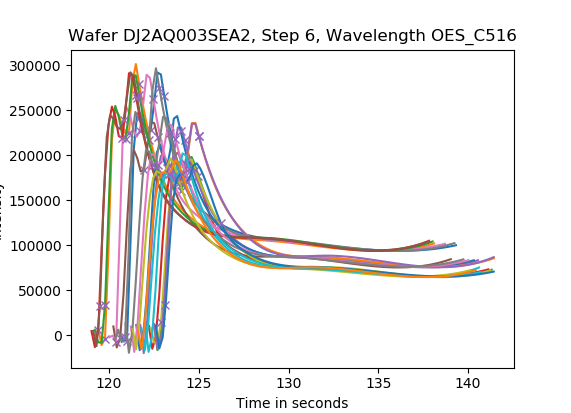

In [95]:
%matplotlib notebook

# Temporary, for my own understanding
peakTime = []
waferScribe = []
for x in range (len(UniqueWafers)):                            # Loop through all wafers
    #fig = plt.figure() # Comment out for single plot of all wafers OR don't comment for multiple plots with single wafer on it
    Tsteps = t_sec[x].loc[Wafer[x]['StepID']==step]            # Series of time in seconds for a given step
    x_int = np.linspace(Tsteps.iloc[0], Tsteps.iloc[-1], 100)  # Create linearly spaced array of 100 time steps
    for y in range(1,2):                                                                     # Loop through OES wavelengths
        plt.title(f"Wafer {UniqueWafers[x]}, Step {step}, Wavelength {OES_col[y]}")          # Plot Title
        Intensity = Wafer[x][OES_col[y]].loc[Wafer[x]['StepID']==step]                       # Intensities for a wavelength
        #plt.plot(Tsteps,Intensity, label=f"{OES_col[y]}")                                    # OG Data
        tck = interpolate.splrep(Tsteps,Intensity, k = 3, s = 1e10)                          # See above
        y_int = interpolate.splev(x_int, tck, der = 0)                                       # See above
        plt.plot(x_int,y_int, label=f"{UniqueWafers[x]}")                                    # Smoothed Data
        first = interpolate.splev(x_int, tck, der = 1)                                       # See above
        #plt.plot(x_int,first, label=f"1st {OES_col[y]}",linestyle = '--',color="tab:red")    # First Derivative Plot
        second = interpolate.splev(x_int, tck, der = 2)                                      # See above
        peaks, _ = find_peaks(second)                                                        # See above
        #peaks = peaks[first[peaks]>0]           # Removing negative first derivative peaks
        #peaks = peaks[y_int[peaks]>0]           # Removing negative smoothed function peaks
        #plt.plot(x_int,second, label=f"2nd {OES_col[y]}",linestyle = ':',color="tab:green")  # Second Derivative Plot
        #plt.plot(x_int[peaks], second[peaks], "x",color="tab:purple", label = "Peaks")       # First Derivative Peaks
        #plt.plot(x_int[peaks], first[peaks], "x",color="tab:purple", label = "Peaks")        # Second Derivative Peaks
        plt.plot(x_int[peaks], y_int[peaks], "x",color="tab:purple", label = "Peaks")        # Smoothed Peaks
        
        try:    # Here to remedy the case of an empty array
            peakTime.append(x_int[peaks[0]]-x_int[0])       # List containing etch time
            waferScribe.append(UniqueWafers[x])             # List with the wafer associated with that etch time
        except IndexError:
            pass
        
    plt.ylabel("Intensity")
    plt.xlabel("Time in seconds")
    #plt.legend()

Coefficient of Determination: 0.029661134765088307


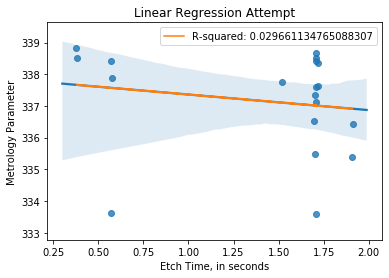

In [92]:
# Perform and present linear regression, matching etch time to metrology parameters for a wafer
etch_time = []
    # DataFrame of wafers and their associated metro parameter
wafer_param_time = met[['waferscribe','ext_mv']] 
    # Turning the two lists of wafers and etch times to a DataFrame
etch_time = pd.DataFrame({'waferscribe':waferScribe,'peaks':peakTime}) 
    # Joining the etch time and wafer parameter into a single DataFrame, matching up the etch and parameter to the correct wafer
result = pd.merge(etch_time, wafer_param_time, on = ['waferscribe'])
    # Performing a linear regression and calculating the slope, intercept, correlation coefficient, probability value, and standard error
slope, intercept, r_value, p_value, std_err = stats.linregress(x=result.peaks, y=result.ext_mv)
print(f"Coefficient of Determination: {r_value**2}")

    # Plotting Linear Regression
fig = plt.figure()
sns.regplot(x=result.peaks, y=result.ext_mv)  # Includes a confidence interval display that I like
    # But won't calculate the R-squared value
plt.plot(result.peaks, result.peaks*slope+intercept, label = f"R-squared: {r_value**2}")  # Plots the linear regression again
plt.title("Linear Regression Attempt")
plt.ylabel("Metrology Parameter")
plt.xlabel("Etch Time, in seconds")
plt.legend()
plt.show()